In [162]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
import h5py
import json
from scipy.stats import pearsonr
from scipy.interpolate import interp1d
from scipy import signal
from functools import reduce

import matplotlib.pyplot as plt

In [163]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Read MoSeq source file

In [4]:
source = '/home/sobolev/nevermind/Miguel/MoSeq/TrainedModels/MoSeqProject_ALLhippoSIT/2023_01_22-16_22_54'
#source = '/home/sobolev/nevermind/Andrey/analysis/DLC/MoSeq/10fps'

colors_bold = [plt.cm.tab20(2*i) for i in range(10)]
colors_tran = [plt.cm.tab20(2*i + 1) for i in range(10)]
colors = colors_bold + colors_tran

moseq_file = os.path.join(source, 'moseq_df.csv')

In [5]:
ds = pd.read_csv(moseq_file)
ds.head()

Unnamed: 0  centroid_x  centroid_y  left_eye_x  left_eye_y  right_eye_x  \
0           0  644.569246  576.211915  664.375584  594.114511   626.029487   
1           1  644.522050  575.806775  646.780232  594.771385   640.361772   
2           2  644.809421  575.589471  650.651585  590.660005   648.823614   
3           3  647.518084  577.345689  653.438402  590.241653   654.516677   
4           4  649.812371  579.924665  654.227105  595.732332   656.695997   

   right_eye_y  left_ear_x  left_ear_y  right_ear_x  ...      neck_x  \
0   559.023179  639.474740  571.141702   631.090666  ...  632.342575   
1   567.631064  650.815236  580.906250   640.795706  ...  644.201793   
2   592.679738  649.468560  575.225772   647.650652  ...  639.839049   
3   600.255483  652.792009  577.970761   650.690372  ...  643.237685   
4   603.923853  653.464199  579.131370   651.554774  ...  647.191913   

       neck_y   heading  velocity_px_s  syllable  syllables_reindexed  \
0  565.248570  1.330798       0.000000        41                    1   
1  560.093120  1.330798      12.236375        41                    1   
2  569.846348  1.291393      10.808466        41                    1   
3  576.533206  1.225636      96.845456        41                    1   
4  578.211660  1.225636     103.553765        41                    1   

   frame_index                                       session_name  \
0            0  009266_hippoSIT_2023-04-24_16-56-55DLC_resnet5...   
1            1  009266_hippoSIT_2023-04-24_16-56-55DLC_resnet5...   
2            2  009266_hippoSIT_2023-04-24_16-56-55DLC_resnet5...   
3            3  009266_hippoSIT_2023-04-24_16-56-55DLC_resnet5...   
4            4  009266_hippoSIT_2023-04-24_16-56-55DLC_resnet5...   

                                   uuid  onset  
0  d7c38211-4539-48f7-9be0-cb57655b621a   True  
1  d7c38211-4539-48f7-9be0-cb57655b621a  False  
2  d7c38211-4539-48f7-9be0-cb57655b621a  False  
3  d7c38211-4539-48f7-9be0-cb57655b621a  False  
4  d7c38211-4539-48f7-9be0-cb57655b621a  False  

[5 rows x 29 columns]

## Create moseq processed file in the session

In [139]:
s_names = ds['session_name'].unique()
session_ms = s_names[3]   # moseq name in the dataframe
session = session_ms[:35] # original session name
session

'009266_hippoSIT_2023-05-04_19-47-15'

In [140]:
source  = '/home/sobolev/nevermind/Andrey/data'
animal      = session.split('_')[0]
sessionpath = os.path.join(source, animal, session)
h5_file     = os.path.join(sessionpath, session + '.h5')
moseq_file  = os.path.join(sessionpath, 'moseq.h5')

In [141]:
with h5py.File(h5_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
    trials = np.array(f['processed']['trial_idxs'])
    cfg = json.loads(f['processed'].attrs['parameters'])

In [142]:
# compare lengths of timeline (~100Hz) and MoSeq detected coords / syllables
ds1 = ds[ds['session_name'] == session_ms]
tl.shape, ds1.shape

((239999, 7), (71815, 29))

In [143]:
# select only required columns
columns_to_drop = ['Unnamed: 0', 'session_name', 'uuid', 'onset']
ds1 = ds1.drop(columns=columns_to_drop)

In [144]:
# convert pixels to meters
def px_to_meters(cfg, x, y):
    cfg_pos = cfg['position']
    pixel_size = cfg_pos['floor_r_in_meters'] / float(cfg_pos['floor_radius'])
    x_m = float(cfg_pos['arena_x'] - x) * pixel_size * (-1 if cfg_pos['flip_x'] else 1)
    y_m = float(cfg_pos['arena_y'] - y) * pixel_size * (-1 if cfg_pos['flip_y'] else 1)
    return x_m, y_m

In [145]:
variables = [x[:-2] for x in ds1.columns if x.find('_x') > 0]
for variable in variables:
    var_x, var_y = variable + '_x', variable + '_y'
    converted = np.array([px_to_meters(cfg, x, y) for x, y in zip(ds1[var_x], ds1[var_y])])
    ds1[var_x] = converted[:, 0]
    ds1[var_y] = converted[:, 1]

In [146]:
# interpolate syllables assuming frames are evenly distributed
t_start, t_end = tl[0][0], tl[-1][0]

x_moseq = np.linspace(t_start, t_end, len(ds1))  # moseq timeline in seconds
moseq_matrix = np.zeros((len(tl), len(ds1.columns)))  # collect moseq data into numpy array

curr_idx = 0
for i, t in enumerate(tl[:, 0]):
    if curr_idx < len(x_moseq) - 1 and \
        np.abs(t - x_moseq[curr_idx]) > np.abs(t - x_moseq[curr_idx + 1]):
        curr_idx += 1
        
    moseq_matrix[i] = np.array(ds1.iloc[curr_idx])

In [147]:
# create a DataFrame from it
moseq_df = pd.DataFrame(moseq_matrix, columns=ds1.columns)

Text(0, 0.5, 'X Position')

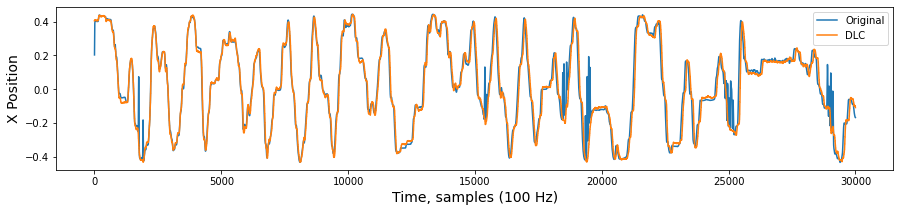

In [148]:
# test centroid position
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(tl[:, 1][:30000], label='Original')
ax.plot(moseq_matrix[:, 0][:30000], label='DLC')
ax.legend(loc='upper right')
ax.set_xlabel('Time, samples (100 Hz)', fontsize=14)
ax.set_ylabel('X Position', fontsize=14)

In [149]:
# save moseq data to the session folder
with h5py.File(moseq_file, 'w') as f:
    ds_h5 = f.create_dataset('moseq', data=moseq_matrix)
    ds_h5.attrs['headers'] = ', '.join(list(ds1.columns))

## Assembly and syllables analysis

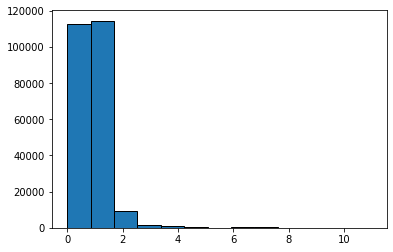

In [161]:
_ = plt.hist(moseq_df['syllables_reindexed'], bins=len(moseq_df['syllables_reindexed'].unique()) + 1, edgecolor='black')

In [437]:
# filter one session for analysis
ds1 = ds[ds['session_name'] == s1]
ds1.loc[:, 'syllables_reindexed'] = ds1['syllables_reindexed'] + 1

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [438]:
ds1.head()

Unnamed: 0  centroid_x  centroid_y   heading  velocity_px_s  syllable  \
143992      143992  613.164947  133.333808  1.978735       0.000000         2   
143993      143993  612.437528  134.409014  1.931724      38.944649         2   
143994      143994  613.875210  136.210232  1.746091      69.138875         2   
143995      143995  614.658842  138.028358  1.751654      59.394399         2   
143996      143996  615.234321  139.767027  1.783242      54.942983         2   

        syllables_reindexed  frame_index  \
143992                   12            0   
143993                   12            1   
143994                   12            2   
143995                   12            3   
143996                   12            4   

                                             session_name  \
143992  hippoSITDLC_resnet50_timeSITOct21shuffle4_7000...   
143993  hippoSITDLC_resnet50_timeSITOct21shuffle4_7000...   
143994  hippoSITDLC_resnet50_timeSITOct21shuffle4_7000...   
143995  hippoSITDLC_resnet50_timeSITOct21shuffle4_7000...   
143996  hippoSITDLC_resnet50_timeSITOct21shuffle4_7000...   

                                        uuid  onset  
143992  da2d7364-153f-4b89-9f7d-42f822b328b6   True  
143993  da2d7364-153f-4b89-9f7d-42f822b328b6  False  
143994  da2d7364-153f-4b89-9f7d-42f822b328b6  False  
143995  da2d7364-153f-4b89-9f7d-42f822b328b6  False  
143996  da2d7364-153f-4b89-9f7d-42f822b328b6  False

In [439]:
# FIXME move it together with the active listening notebook
characteristic_assemblies = [
    ['008229_hippoSIT_2022-05-17_21-44-43', 6, 6.5], # 400 - 800
    ['008229_hippoSIT_2022-05-16_20-36-44', 7, 9],  # 100 - 400
    ['008229_hippoSIT_2022-05-20_15-54-39', 11, 1.2],  # 0 - 400
    ['008229_hippoSIT_2022-05-18_14-36-18', 6, 15]  # 300 - 750
]

In [440]:
# reading active listening assembly / unit
session, ass_id, thresh = characteristic_assemblies[0]
#unit_name = '8-8'

animal  = session.split('_')[0]
sessionpath = os.path.join('/home/sobolev/nevermind/Andrey/data', animal, session)
h5name  = os.path.join('/home/sobolev/nevermind/Andrey/data', animal, session, session + '.h5')

with h5py.File(h5name, 'r') as f:
    tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
    
    # if based on assembly
    i_rate = np.array(f['assemblies'][str(ass_id)])
    
    # if based on single neuron
    #i_rate = np.array(f['units'][unit_name][H5NAMES.inst_rate['name']])

In [152]:
# reading syllables
syls = np.array(ds1['syllables_reindexed'])
syls_t = np.linspace(tl[:, 0][0], tl[:, 0][-1], len(syls))

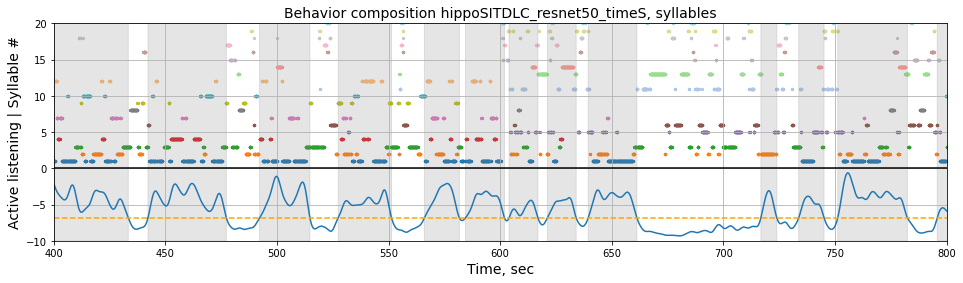

In [446]:
t1, t2 = 400, 800
syls_filt = np.where(syls == 0)[0]
i_rate_normed = i_rate / (i_rate.max()/10)
th_normed = thresh / (i_rate.max()/10)

fig, ax = plt.subplots(figsize=(16, 4))

for i in range(20):
    idxs = np.where(syls == i + 1)[0]
    ax.scatter(syls_t[idxs], syls[idxs], s=5, color=colors[i])
    
#ax.scatter(syls_t[syls_filt], syls[syls_filt], s=5, color='red')
ax.plot(tl[:, 0], i_rate_normed - i_rate_normed.max())
ax.fill_between(tl[:, 0], 0, 10, where=i_rate > thresh, color='grey', alpha=0.2, transform=ax.get_xaxis_transform())

ax.grid()
ax.axhline(0, color='black')
ax.axhline(-i_rate_normed.max() + th_normed, color='orange', ls='--')
ax.set_xlim(t1, t2)
ax.set_ylim(-i_rate_normed.max(), 20)
ax.set_ylabel('Active listening | Syllable #', fontsize=14)
ax.set_xlabel('Time, sec', fontsize=14)
ax.set_title('Behavior composition %s, syllables' % s1[:26], fontsize=14)
#fig.tight_layout()
fig.savefig(os.path.join(source, 'behav_comp_in_time_%s.png' % session[:26]))

## Correlation with binary syllable

In [447]:
syl1 = np.zeros(len(syls))
syl1[np.where(syls == 1)] = 1
syl_interp = np.interp(tl[:, 0], syls_t, syl1)

act_list = np.zeros(len(i_rate))
act_list[i_rate > thresh] = 1

pearsonr(syl_interp, act_list)

(0.29863420261741347, 0.0)

## Syllable proportion in diff states

In [444]:
idxs_filt = np.where((tl[:, 0] < 600) | (tl[:, 0] > 1800))[0]  # light filter
idxs_filt = np.where((tl[:, 0] > 0))[0]  # no filter

probs = []

act_list = np.zeros(len(i_rate))
act_list[i_rate > thresh] = 1
idxs_active  = np.where(act_list == 1)[0]
idxs_passive = np.where(act_list == 0)[0]
    
for syllable in np.unique(syls):
    syl1 = np.zeros(len(syls))
    syl1[np.where(syls == syllable)[0]] = 1
    syl_interp = np.interp(tl[:, 0], syls_t, syl1)
    
    idxs_syl1 = np.where(syl_interp == 1)[0]

    idxs_syl_active  = reduce(np.intersect1d, (idxs_syl1, idxs_active, idxs_filt))
    idxs_syl_passive = reduce(np.intersect1d, (idxs_syl1, idxs_passive, idxs_filt))

    p_syl_active  = len(idxs_syl_active)  / len( np.intersect1d(idxs_active, idxs_filt) )
    p_syl_passive = len(idxs_syl_passive) / len( np.intersect1d(idxs_passive, idxs_filt))
    #p_syl = len(np.intersect1d(idxs_syl1, idxs_light)) / len(idxs_light)

    probs.append([p_syl_active, p_syl_passive])
    
probs = np.array(probs)

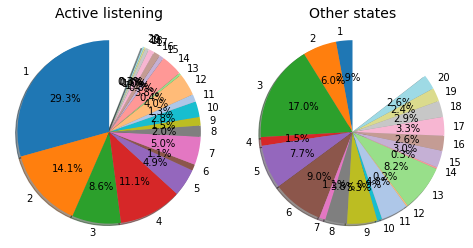

In [445]:
max_syl = 20

labels  = np.unique(syls)[:max_syl]
sizes_active  = probs[:, 0][:max_syl]
sizes_passive = probs[:, 1][:max_syl]
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig = plt.figure(figsize=(8, 4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.pie(sizes_active, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, normalize=False, colors=colors)
ax1.axis('equal')
ax1.set_title('Active listening', fontsize=14)

ax2 = fig.add_subplot(1, 2, 2)
ax2.pie(sizes_passive, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, normalize=False, colors=colors)
ax2.axis('equal')
ax2.set_title('Other states', fontsize=14)

fig.savefig(os.path.join(source, 'behav_comp_pie_%s.png' % session[:26]))

## Syllable occurence

In [150]:
probabilities = []
coeffs = []
#idxs_actl = np.where(i_rate > 6.5)[0]
    
for syllable in np.unique(syls)[:20]:

    syl1 = np.zeros(len(syls))
    syl1[np.where(syls == syllable)[0]] = 1
    syl_interp = np.interp(tl[:, 0], syls_t, syl1)

    idxs_syl1 = np.where(syl_interp == 1)[0]
    i_sect = np.intersect1d(idxs_syl1, idxs_actl)

    coeffs.append(len(np.where(syls == syllable)[0]) / len(syls))
    probabilities.append(0 if len(idxs_syl1) == 0 else len(i_sect)/len(idxs_syl1))

NameError: name 'i_rate' is not defined

NameError: name 'syls' is not defined

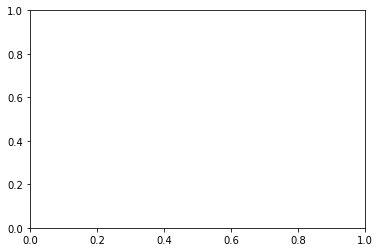

In [151]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(np.unique(syls)[:20], probabilities, width=5*np.array(coeffs))
ax.axhline(0.5, ls='--')
ax.set_xlabel('Syllable #', fontsize=14)
ax.set_ylabel('Probability dur. Active listening #', fontsize=14)